In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 1s 14us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential() #因为需要将同一个模型多次实例化，所以用一个函数来构建模型
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


K折验证

In [7]:
import numpy as np 

k = 4
num_val_samples = len(train_data) // k

In [8]:

num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold # ', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] #准备验证数据：第K个分区的数据
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(#准备训练数据：其它所有分区的数据
                                        [train_data[:i * num_val_samples],
                                        train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate(
                                            [train_targets[:i * num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                            axis=0)
    
    model = build_model() #构建keras模型(已编译)
    model.fit(partial_train_data,partial_train_targets,
             epochs=num_epochs,batch_size=1,verbose=0)#训练模型（静默模式，verbose=0）
    val_mse, val_mae = model.evaluate(val_data,val_targets,verbose=0)#在验证数据上评估模型
    all_scores.append(val_mae)
    
all_scores

processing fold #  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold #  1
processing fold #  2
processing fold #  3


[2.0392341212470932, 2.299512213999682, 2.9049261867409886, 2.377180003883815]

In [9]:
np.mean(all_scores)

2.4052131314678946

保存每折的验证结果

In [10]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Processing fold #',i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
                        [train_data[:i *num_val_samples],
                        train_data[(i + 1) * num_val_samples:]],
                        axis=0)
    partial_train_targets = np.concatenate(
                        [train_targets[:i * num_val_samples],
                        train_targets[(i+1)* num_val_samples:]],
                        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
                       validation_data=(val_data,val_targets),
                       epochs=num_epochs, batch_size=1,verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories])  for i in range(num_epochs)
]

average_mae_history

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


[4.796106038707318,
 3.3880550861358643,
 3.0611881324560337,
 2.7475562237276887,
 2.800408357440835,
 2.702081851439901,
 2.6395967868295047,
 2.6333359680553476,
 2.5629194762447094,
 2.593019963491081,
 2.491936976366704,
 2.7344448837903466,
 2.5160240052950265,
 2.401027850585409,
 2.4345026028038252,
 2.4221092014029475,
 2.480590139285172,
 2.4462761111778786,
 2.3630037602811758,
 2.4997537501967777,
 2.3816549022599025,
 2.3545452403550104,
 2.314070486786342,
 2.3357000693236247,
 2.5076366721993626,
 2.3334447782818635,
 2.286031684072891,
 2.407076013560342,
 2.3226595255407956,
 2.447769499061131,
 2.3686287237866086,
 2.491360071862098,
 2.3524830258718814,
 2.458562215956131,
 2.4361598409048404,
 2.2803648828279854,
 2.383226753461479,
 2.3232351211037967,
 2.3115938842886745,
 2.3808513525689,
 2.2741802104628914,
 2.304325568794024,
 2.3146737967387283,
 2.2998687583621185,
 2.239617864094158,
 2.4721675934177814,
 2.294112213767401,
 2.3518157430214455,
 2.361867938

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1,len(average_mae_history) + 1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

NameError: name 'average_mae_history' is not defined

绘制验证分数（删除前10 个数据点）

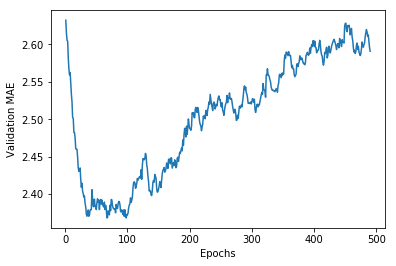

In [10]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history) + 1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [ ]:
model = build_model() #一个全新的编译好的模型
model.fit(train_data, train_targets, #        在所有训练数据上训练模型
  epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)